# Integrating scCAT-seq cell lines

## Imports

In [1]:
# Biology
import scanpy as sc
import anndata as ad
import muon as mu

In [2]:
# Maths
import pandas as pd
import numpy as np
import torch
from torch import optim
from umap import UMAP

In [3]:
# Our packages
from scmiot import models, pl, tl

In [4]:
import sknetwork

In [5]:
import matplotlib.pyplot as plt

## Load data

In [6]:
mdata = mu.read_h5mu('../datasets/Liu/preprocessed/liu.h5mu.gz')
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Varying genes

In [7]:
# Highly variable genes
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=4, min_disp=0.5, n_top_genes=100)
np.sum(rna.var.highly_variable)

100

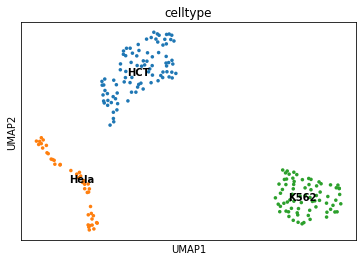

In [8]:
# Umap
sc.pp.scale(rna, zero_center=False)
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=10)
sc.tl.umap(rna, spread=1.5, min_dist=.5)
sc.pl.umap(rna, color="celltype", legend_loc="on data", size=50)

## Preprocess ATAC

In [9]:
sc.pp.highly_variable_genes(atac, min_mean=1e-5, max_mean=4, min_disp=1, n_top_genes=100)
np.sum(atac.var.highly_variable)

100

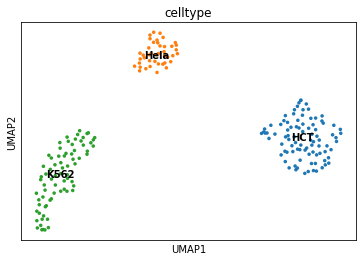

In [10]:
# Umap
sc.pp.scale(atac, zero_center=False)
sc.tl.pca(atac, svd_solver='arpack')
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=10)
sc.tl.umap(atac, spread=1.5, min_dist=.5)
sc.pl.umap(atac, color="celltype", legend_loc="on data", size=50)

## Perform NMF

In [70]:
from importlib import reload
reload(models)

<module 'scmiot.models' from '/users/csb/huizing/anaconda3/lib/python3.8/site-packages/scmiot/models.py'>

In [71]:
eps = .1
latent_dim = 4
rho_h = .05
rho_w = .05

In [72]:
nmf = models.OTintNMF(latent_dim=latent_dim, rho_h=rho_h, rho_w=rho_w, eps=eps, cost='euclidean', pca_cost=True)

In [73]:
nmf.fit_transform(
    mdata, max_iter_inner=1_000, max_iter=100,
    device='cpu', dtype=torch.float, lr=1,
    tol_inner=1e-9, tol_outer=1e-5)

 14%|█▍        | 28/200 [00:12<01:18,  2.19it/s, loss=-0.5037505, loss_inner=0.39981624, inner_steps=22, gpu_memory_allocated=0]


## Visualize losses

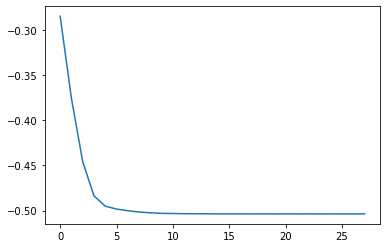

In [74]:
plt.plot(nmf.losses)

/users/csb/huizing/anaconda3/lib/python3.8/site-packages/scmiot/pl.py:54: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


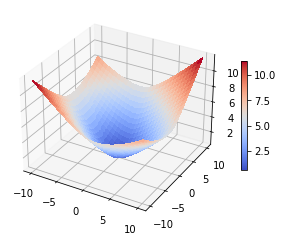

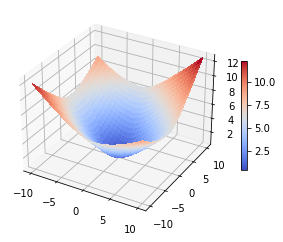

In [75]:
pl.plot_loss_w(nmf)
pl.plot_loss_h(nmf)

## Viz

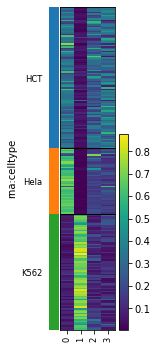

In [76]:
pl.heatmap(mdata, 'W_OT', 'rna:celltype')

In [77]:
tl.umap(mdata, 'W_OT', metric='l1', min_dist=.6, spread=1)

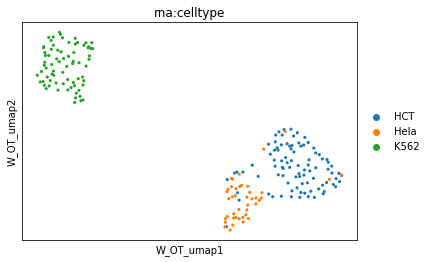

In [78]:
mu.pl.embedding(mdata, 'W_OT_umap', 'rna:celltype', size=40)

## Clustering

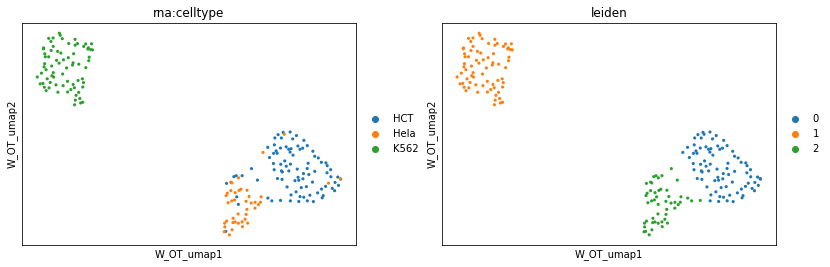

In [79]:
tl.leiden(mdata, resolution=.1)
mu.pl.embedding(mdata, 'W_OT_umap', ['rna:celltype', 'leiden'], size=40)

## Choose best K

In [88]:
reload(tl)

<module 'scmiot.tl' from '/users/csb/huizing/anaconda3/lib/python3.8/site-packages/scmiot/tl.py'>

In [89]:
losses = []
entropies_h = []
entropies_w = []
kk = [5, 10, 30, 50, 100]
for k in kk:
    nmf.update_latent_dim(k)
    nmf.fit_transform(
        mdata, max_iter_inner=1_000, max_iter=100,
        device='cpu', dtype=torch.float, lr=1,
        tol_inner=1e-9, tol_outer=1e-5)
    k_metrics = tl.k_metric(nmf)
    losses.append(k_metrics['ot_loss'])
    entropies_h.append(k_metrics['entropy_h'])
    entropies_w.append(k_metrics['entropy_w'])

 22%|██▏       | 44/200 [00:06<00:21,  7.32it/s, loss=-0.7488387, loss_inner=0.33035797, inner_steps=18, gpu_memory_allocated=0]


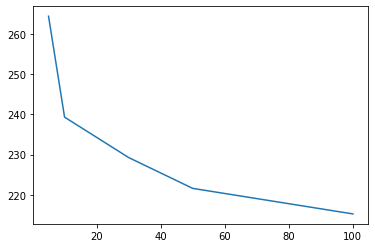

In [90]:
plt.plot(kk, losses)

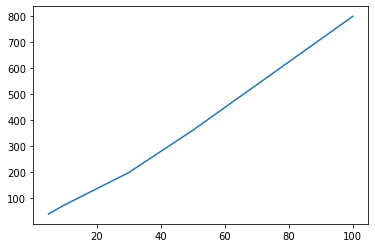

In [91]:
plt.plot(kk, entropies_h)

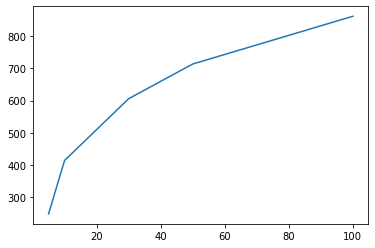

In [92]:
plt.plot(kk, entropies_w)